# 06. PyTorch Transfer Learning

> **Note:** This notebook uses `torchvision`'s new [multi-weight support API (available in `torchvision` v0.13+)](https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/).

We've built a few models by hand so far.

But their performance has been poor.

You might be thinking, **is there a well-performing model that already exists for our problem?**

And in the world of deep learning, the answer is often *yes*.

We'll see how by using a powerful technique called [**transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning).

## What is transfer learning?

**Transfer learning** allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.

For example, we can take the patterns a computer vision model has learned from datasets such as [ImageNet](https://www.image-net.org/) (millions of images of different objects) and use them to power our FoodVision Mini model.

Or we could take the patterns from a [language model](https://developers.google.com/machine-learning/glossary#masked-language-model) (a model that's been through large amounts of text to learn a representation of language) and use them as the basis of a model to classify different text samples.

The premise remains: find a well-performing existing model and apply it to your own problem.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-transfer-learning-example-overview.png" alt="transfer learning overview on different problems" width=900/>

*Example of transfer learning being applied to computer vision and natural language processing (NLP). In the case of computer vision, a computer vision model might learn patterns on millions of images in ImageNet and then use those patterns to infer on another problem. And for NLP, a language model may learn the structure of language by reading all of Wikipedia (and perhaps more) and then apply that knowledge to a different problem.*

## Why use transfer learning?

There are two main benefits to using transfer learning:

1. Can leverage an existing model (usually a neural network architecture) proven to work on problems similar to our own.
2. Can leverage a working model which has **already learned** patterns on similar data to our own. This often results in achieving **great results with less custom data**.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-transfer-learning-for-foodvision-mini%20.png" alt="transfer learning applied to FoodVision Mini" width=900/>

*We'll be putting these to the test for our FoodVision Mini problem, we'll take a computer vision model pretrained on ImageNet and try to leverage its underlying learned representations for classifying images of pizza, steak and sushi.*

Both research and practice support the use of transfer learning too.

A finding from a recent machine learning research paper recommended practioner's use transfer learning wherever possible.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-how-to-train-your-vit-section-6-transfer-learning-highlight.png" width=900 alt="how to train your vision transformer paper section 6, advising to use transfer learning if you can"/>

*A study into the effects of whether training from scratch or using transfer learning was better from a practioner's point of view, found transfer learning to be far more beneficial in terms of cost and time. **Source:** [How to train your ViT? Data, Augmentation, and Regularization in Vision Transformers](https://arxiv.org/abs/2106.10270) paper section 6 (conclusion).*

And Jeremy Howard (founder of [fastai](https://www.fast.ai/)) is a big proponent of transfer learning.

> The things that really make a difference (transfer learning), if we can do better at transfer learning, it’s this world changing thing. Suddenly lots more people can do world-class work with less resources and less data. — [Jeremy Howard on the Lex Fridman Podcast](https://youtu.be/Bi7f1JSSlh8?t=72)




## Where to find pretrained models

The world of deep learning is an amazing place.

So amazing that many people around the world share their work.

Often, code and pretrained models for the latest state-of-the-art research is released within a few days of publishing.

And there are several places you can find pretrained models to use for your own problems.

| **Location** | **What's there?** | **Link(s)** | 
| :----- | :----- | :----- |
| **PyTorch domain libraries** | Each of the PyTorch domain libraries (`torchvision`, `torchtext`) come with pretrained models of some form. The models there work right within PyTorch. | [`torchvision.models`](https://pytorch.org/vision/stable/models.html), [`torchtext.models`](https://pytorch.org/text/main/models.html), [`torchaudio.models`](https://pytorch.org/audio/stable/models.html), [`torchrec.models`](https://pytorch.org/torchrec/torchrec.models.html) |
| **HuggingFace Hub** | A series of pretrained models on many different domains (vision, text, audio and more) from organizations around the world. There's plenty of different datasets too. | https://huggingface.co/models, https://huggingface.co/datasets | 
| **`timm` (PyTorch Image Models) library** | Almost all of the latest and greatest computer vision models in PyTorch code as well as plenty of other helpful computer vision features. | https://github.com/rwightman/pytorch-image-models|
| **Paperswithcode** | A collection of the latest state-of-the-art machine learning papers with code implementations attached. You can also find benchmarks here of model performance on different tasks. | https://paperswithcode.com/ | 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-transfer-learning-where-to-find-pretrained-models.png" alt="different locations to find pretrained neural network models" width=900/>

*With access to such high-quality resources as above, it should be common practice at the start of every deep learning problem you take on to ask, "Does a pretrained model exist for my problem?"*

> **Exercise:** Spend 5-minutes going through [`torchvision.models`](https://pytorch.org/vision/stable/models.html) as well as the [HuggingFace Hub Models page](https://huggingface.co/models), what do you find? (there's no right answers here, it's just to practice exploring) 

## What we're going to cover

We're going to take a pretrained model from `torchvision.models` and customise it to work on (and hopefully improve) our FoodVision Mini problem.

| **Topic** | **Contents** |
| :----- | :----- |
| **0. Getting setup** | We've written a fair bit of useful code over the past few sections, let's download it and make sure we can use it again. |
| **1. Get data** | Let's get the pizza, steak and sushi image classification dataset we've been using to try and improve our model's results. |
| **2. Create Datasets and DataLoaders** | We'll use the `data_setup.py` script we wrote in chapter 05. PyTorch Going Modular to setup our DataLoaders. |
| **3. Get and customise a pretrained model** | Here we'll download a pretrained model from `torchvision.models` and customise it to our own problem. | 
| **4. Train model** | Let's see how the new pretrained model goes on our pizza, steak, sushi dataset. We'll use the training functions we created in the previous chapter. |
| **5. Evaluate the model by plotting loss curves** | How did our first transfer learning model go? Did it overfit or underfit?  |
| **6. Make predictions on images from the test set** | It's one thing to check out a model's evaluation metrics but it's another thing to view its predictions on test samples, let's *visualize, visualize, visualize*! |

## 0. Getting setup

Let's get started by importing/downloading the required modules for this section.

To save us writing extra code, we're going to be leveraging some of the Python scripts (such as `data_setup.py` and `engine.py`) we created in the previous section, [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).

Specifically, we're going to download the [`going_modular`](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular) directory from the `pytorch-deep-learning` repository (if we don't already have it).

We'll also get the [`torchinfo`](https://github.com/TylerYep/torchinfo) package if it's not available. 

`torchinfo` will help later on to give us a visual representation of our model.

> **Note:** As of June 2022, this notebook uses the nightly versions of `torch` and `torchvision` as `torchvision` v0.13+ is required for using the updated multi-weights API. You can install these using the command below.

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 10, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 10, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
#     !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.10.0+cu102
torchvision version: 0.11.0+cu102


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn

import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models
from torchvision.datasets import ImageFolder
from torchsummary import summary
from going_modular import data_setup, engine, utils, train, model_builder

Now let's setup device agnostic code.

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`.

In [4]:
# Setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 1. Get data

Before we can start to use **transfer learning**, we'll need a dataset.

To see how transfer learning compares to our previous attempts at model building, we'll download the same dataset we've been using for FoodVision Mini.

Let's write some code to download the [`pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) dataset from the course GitHub and then unzip it.

We can also make sure if we've already got the data, it doesn't redownload. 

In [5]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory exists.


In [8]:
file_dir = 'data/food_50_percent.zip'

file_path = Path('data/new_food_file')
if file_path.is_dir():
    print(f'Folder already Exists')
else:
    print(f'{file_path} is not found, Creating one !!!')
    file_path.mkdir(parents=True, exist_ok=True)
    
    with zipfile.ZipFile(file_dir, "r") as zip_ref:
        print('Unzipping pizza, steak, sushi data...')
        zip_ref.extractall(file_path)

Folder already Exists


Excellent!

Now we've got the same dataset we've been using previously, a series of images of pizza, steak and sushi in standard image classification format.

Let's now create paths to our training and test directories.

In [9]:
train_dir = file_path / 'food-101/train'
test_dir = file_path / 'food-101/test'

train_dir, test_dir

(WindowsPath('data/new_food_file/food-101/train'),
 WindowsPath('data/new_food_file/food-101/test'))

## 2. Create Datasets and DataLoaders

Since we've downloaded the `going_modular` directory, we can use the [`data_setup.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/data_setup.py) script we created in section [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/#2-create-datasets-and-dataloaders-data_setuppy) to prepare and setup our DataLoaders.

But since we'll be using a pretrained model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html), there's a specific transform we need to prepare our images first.

### 2.1 Creating a transform for `torchvision.models` (manual creation)

> **Note:** As of `torchvision` v0.13+, there's an update to how data transforms can be created using `torchvision.models`. I've called the previous method "manual creation" and the new method "auto creation". This notebook showcases both.

When using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**.

Prior to `torchvision` v0.13+, to create a transform for a pretrained model in `torchvision.models`, the documentation stated:

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. 
>
> The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. 
>
> You can use the following transform to normalize:
>
> ```
> normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
>                                  std=[0.229, 0.224, 0.225])
> ```

The good news is, we can achieve the above transformations with a combination of: 

| **Transform number** | **Transform required** | **Code to perform transform** | 
| :----- | :----- | :----- |
| 1 | Mini-batches of size `[batch_size, 3, height, width]` where height and width are at least 224x224^. | `torchvision.transforms.Resize()` to resize images into `[3, 224, 224]`^ and `torch.utils.data.DataLoader()` to create batches of images. |
| 2 | Values between 0 & 1. | `torchvision.transforms.ToTensor()` |
| 3 | A mean of `[0.485, 0.456, 0.406]` (values across each colour channel). | `torchvision.transforms.Normalize(mean=...)` to adjust the mean of our images.  |
| 4 | A standard deviation of `[0.229, 0.224, 0.225]` (values across each colour channel). | `torchvision.transforms.Normalize(std=...)` to adjust the standard deviation of our images.  | 

> **Note:** ^some pretrained models from `torchvision.models` in different sizes to `[3, 224, 224]`, for example, some might take them in `[3, 240, 240]`. For specific input image sizes, see the documentation.

> **Question:** *Where did the mean and standard deviation values come from? Why do we need to do this?*
>
> These were calculated from the data. Specifically, the ImageNet dataset by taking the means and standard deviations across a subset of images.
>
> We also don't *need* to do this. Neural networks are usually quite capable of figuring out appropriate data distributions (they'll calculate where the mean and standard deviations need to be on their own) but setting them at the start can help our networks achieve better performance quicker.

Let's compose a series of `torchvision.transforms` to perform the above steps.

In [10]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = T.Compose([
    T.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    T.ToTensor(), # 2. Turn image values to between 0 & 1 
    T.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

Wonderful!

Now we've got a **manually created series of transforms** ready to prepare our images, let's create training and testing DataLoaders.

We can create these using the `create_dataloaders` function from the [`data_setup.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/data_setup.py) script we created in [05. PyTorch Going Modular Part 2](https://www.learnpytorch.io/05_pytorch_going_modular/#2-create-datasets-and-dataloaders-data_setuppy).

We'll set `batch_size=32` so our model see's mini-batches of 32 samples at a time.

And we can transform our images using the transform pipeline we created above by setting `transform=manual_transform`.

> **Note:** I've included this manual creation of transforms in this notebook because you may come across resources that use this style. It's also important to note that because these transforms are manually created, they're also infinitely customizable. So if you wanted to included data augmentation techniques in your transforms pipeline, you could.

In [14]:
train_tsfm = T.Compose([T.Resize((224,224)),
                        T.RandomHorizontalFlip(p=0.3),
                        T.GaussianBlur(3),
                        T.ToTensor(),
                        T.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
                        ])

test_tsfm = T.Compose([T.Resize((224,224)),
                        T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
                       ])

In [79]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloader(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              imagefolder=ImageFolder,
                                                                              transform=[manual_transforms, manual_transforms],
                                                                              dataloader=DataLoader,
                                                                              batch_size=32,
                                                                              num_workers=0,
                                                                             )
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2b0dc2a7280>,
 ['pizza', 'steak', 'sushi'])

In [80]:
# Check out single image size/shape
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


### 2.2 Creating a transform for `torchvision.models` (auto creation)

As previously stated, when using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**.

Above we saw how to manually create a transform for a pretrained model.

But as of `torchvision` v0.13+, an automatic transform creation feature has been added.

When you setup a model from `torchvision.models` and select the pretrained model weights you'd like to use, for example, say we'd like to use:
    
```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
```

Where,
* `EfficientNet_B0_Weights` is the model architecture weights we'd like to use (there are many differnt model architecture options in `torchvision.models`).
* `DEFAULT` means the *best available* weights (the best performance in ImageNet).
    * **Note:** Depending on the model architecture you choose, you may also see other options such as `IMAGENET_V1` and `IMAGENET_V2` where generally the higher version number the better. Though if you want the best available, `DEFAULT` is the easiest option. See the [`torchvision.models` documentation](https://pytorch.org/vision/main/models.html) for more.
    
Let's try it out.

In [21]:
# Get a set of pretrained model weights
model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')

Notice how `auto_transforms` is very similar to `manual_transforms`, the only difference is that `auto_transforms` came with the model architecture we chose, where as we had to create `manual_transforms` by hand.

The benefit of automatically creating a transform through `weights.transforms()` is that you ensure you're using the same data transformation as the pretrained model used when it was trained.

However, the tradeoff of using automatically created transforms is a lack of customization.


## 3. Getting a pretrained model

Alright, here comes the fun part!

Over the past few notebooks we've been building PyTorch neural networks from scratch.

And while that's a good skill to have, our models haven't been performing as well as we'd like. 

That's where **transfer learning** comes in.

The whole idea of transfer learning is to **take an already well-performing model on a problem-space similar to yours and then customising it to your use case**.

Since we're working on a computer vision problem (image classification with FoodVision Mini), we can find pretrained classification models in [`torchvision.models`](https://pytorch.org/vision/stable/models.html#classification).

Exploring the documentation, you'll find plenty of common computer vision architecture backbones such as:

| **Architecuture backbone** | **Code** |
| :----- | :----- |
| [ResNet](https://arxiv.org/abs/1512.03385)'s | `torchvision.models.resnet18()`, `torchvision.models.resnet50()`... | 
| [VGG](https://arxiv.org/abs/1409.1556) (similar to what we used for TinyVGG) | `torchvision.models.vgg16()` | 
| [EfficientNet](https://arxiv.org/abs/1905.11946)'s | `torchvision.models.efficientnet_b0()`, `torchvision.models.efficientnet_b1()`... | 
| [VisionTransformer](https://arxiv.org/abs/2010.11929) (ViT's)| `torchvision.models.vit_b_16()`, `torchvision.models.vit_b_32()`... | 
| [ConvNeXt](https://arxiv.org/abs/2201.03545) | `torchvision.models.convnext_tiny()`,  `torchvision.models.convnext_small()`... |
| More available in `torchvision.models` | `torchvision.models...` | 

### 3.1 Which pretrained model should you use?

It depends on your problem/the device you're working with.

Generally, the higher number in the model name (e.g. `efficientnet_b0()` -> `efficientnet_b1()` -> `efficientnet_b7()`) means *better performance* but a *larger* model.

You might think better performance is *always better*, right?

That's true but **some better performing models are too big for some devices**.

For example, say you'd like to run your model on a mobile-device, you'll have to take into account the limited compute resources on the device, thus you'd be looking for a smaller model.

But if you've got unlimited compute power, as [*The Bitter Lesson*](http://www.incompleteideas.net/IncIdeas/BitterLesson.html) states, you'd likely take the biggest, most compute hungry model you can.

Understanding this **performance vs. speed vs. size tradeoff** will come with time and practice.

For me, I've found a nice balance in the `efficientnet_bX` models. 

As of May 2022, [Nutrify](https://nutrify.app) (the machine learning powered app I'm working on) is powered by an `efficientnet_b0`.

[Comma.ai](https://comma.ai/) (a company that makes open source self-driving car software) [uses an `efficientnet_b2`](https://geohot.github.io/blog/jekyll/update/2021/10/29/an-architecture-for-life.html) to learn a representation of the road.

> **Note:** Even though we're using `efficientnet_bX`, it's important not to get too attached to any one architecture, as they are always changing as new research gets released. Best to experiment, experiment, experiment and see what works for your problem. 

### 3.2 Setting up a pretrained model

The pretrained model we're going to be using is [`torchvision.models.efficientnet_b0()`](https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0).

The architecture is from the paper *[EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)*.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-effnet-b0-feature-extractor.png" alt="efficienet_b0 from PyTorch torchvision feature extraction model" width=900/>

*Example of what we're going to create, a pretrained [`EfficientNet_B0` model](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html) from `torchvision.models` with the output layer adjusted for our use case of classifying pizza, steak and sushi images.*

We can setup the `EfficientNet_B0` pretrained ImageNet weights using the same code as we used to create the transforms.


```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights for ImageNet
```

This means the model has already been trained on millions of images and has a good base representation of image data.

The PyTorch version of this pretrained model is capable of achieving ~77.7% accuracy across ImageNet's 1000 classes.

We'll also send it to the target device.

In [270]:
# model = models.efficientnet_b0(pretrained=True)
# model = models.efficientnet_b2(pretrained=True)
# model = models.resnet101(pretrained=True)
# model = models.resnet18(pretrained=True)
model = models.mobilenet_v3_small(pretrained=True)
# model = models.mobilenet_v3_large(pretrained=True)
utils.to_device(model, device)

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride

> **Note:** In previous versions of `torchvision`, you'd create a prertained model with code like:
>
> `model = torchvision.models.efficientnet_b0(pretrained=True).to(device)`
>
> However, running this using `torchvision` v0.13+ will result in errors such as the following:
> 
> `UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.`
>
> And...
> 
> `UserWarning: Arguments other than a weight enum or None for weights are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing weights=EfficientNet_B0_Weights.IMAGENET1K_V1. You can also use weights=EfficientNet_B0_Weights.DEFAULT to get the most up-to-date weights.`

If we print the model, we get something similar to the following:

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnetb0-model-print-out.png" alt="output of printing the efficientnet_b0 model from torchvision.models" width=900/>

Lots and lots and lots of layers.

This is one of the benefits of transfer learning, taking an existing model, that's been crafted by some of the best engineers in the world and applying to your own problem.

Our `efficientnet_b0` comes in three main parts:
1. `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as **features** or **feature extractor**, "the base layers of the model learn the different **features** of images").
2. `avgpool` - Takes the average of the output of the `features` layer(s) and turns it into a **feature vector**.
3. `classifier` - Turns the **feature vector** into a vector with the same dimensionality as the number of required output classes (since `efficientnet_b0` is pretrained on ImageNet and because ImageNet has 1000 classes, `out_features=1000` is the default). 

### 3.3 Getting a summary of our model with `torchinfo.summary()` or `torchsummary.summary()`

To learn more about our model, let's use `torchinfo`'s [`summary()` method](https://github.com/TylerYep/torchinfo#documentation).

To do so, we'll pass in:
 * `model` - the model we'd like to get a summary of.
 * `input_size` - the shape of the data we'd like to pass to our model, for the case of `efficientnet_b0`, the input size is `(batch_size, 3, 224, 224)`, though [other variants of `efficientnet_bX` have different input sizes](https://github.com/pytorch/vision/blob/d2bfd639e46e1c5dc3c177f889dc7750c8d137c7/references/classification/train.py#L92-L93).
    * **Note:** Many modern models can handle input images of varying sizes thanks to [`torch.nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html), this layer adaptively adjusts the `output_size` of a given input as required. You can try this out by passing different size input images to `summary()` or your models.
 * `col_names` - the various information columns we'd like to see about our model. 
 * `col_width` - how wide the columns should be for the summary.
 * `row_settings` - what features to show in a row.

In [271]:
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-torchinfo-summary-unfrozen-layers.png" alt="output of torchinfo.summary() when passed our model with all layers as trainable" width=900/>

Woah!

Now that's a big model!

From the output of the summary, we can see all of the various input and output shape changes as our image data goes through the model.

And there are a whole bunch more total parameters (pretrained weights) to recognize different patterns in our data.

For reference, our model from previous sections, **TinyVGG had 8,083 parameters vs. 5,288,548 parameters for `efficientnet_b0`, an increase of ~654x**!

What do you think, will this mean better performance?

### 3.4 Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the `features` section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnet-changing-the-classifier-head.png" alt="changing the efficientnet classifier head to a custom number of outputs" width=900/>

*You can customise the outputs of a pretrained model by changing the output layer(s) to suit your problem. The original `torchvision.models.efficientnet_b0()` comes with `out_features=1000` because there are 1000 classes in ImageNet, the dataset it was trained on. However, for our problem, classifying images of pizza, steak and sushi we only need `out_features=3`.*

Let's freeze all of the layers/parameters in the `features` section of our `efficientnet_b0` model.

> **Note:** To *freeze* layers means to keep them how they are during training. For example, if your model has pretrained layers, to *freeze* them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad=False`.

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with `requires_grad=False` is "untrainable" or "frozen" in place.

In [272]:
for param in model.parameters():
    param.requires_grad = False

Feature extractor layers frozen!

Let's now adjust the output layer or the `classifier` portion of our pretrained model to our needs.

Right now our pretrained model has `out_features=1000` because there are 1000 classes in ImageNet. 

However, we don't have 1000 classes, we only have three, pizza, steak and sushi.

We can change the `classifier` portion of our model by creating a new series of layers.

The current `classifier` consists of:

```
(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
```

We'll keep the `Dropout` layer the same using [`torch.nn.Dropout(p=0.2, inplace=True)`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

> **Note:** [Dropout layers](https://developers.google.com/machine-learning/glossary#dropout_regularization) randomly remove connections between two neural network layers with a probability of `p`. For example, if `p=0.2`, 20% of connections between neural network layers will be removed at random each pass. This practice is meant to help regularize (prevent overfitting) a model by making sure the connections that remain learn features to compensate for the removal of the other connections (hopefully these remaining features are *more general*). 

And we'll keep `in_features=1280` for our `Linear` output layer but we'll change the `out_features` value to the length of our `class_names` (`len(['pizza', 'steak', 'sushi']) = 3`).

Our new `classifier` layer should be on the same device as our `model`. 

In [279]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
# model.fc = torch.nn.Sequential(
# #     torch.nn.Dropout(p=0.2, inplace=True), 
#     torch.nn.Linear(in_features=512, 
#                     out_features=output_shape, # same number of output units as our number of classes
#                     bias=True)).to(device)

model.classifier = torch.nn.Sequential(torch.nn.Linear(in_features=576, out_features=1024),
                                       torch.nn.Hardswish(),
#                                        torch.nn.Dropout(p=0.2, inplace=True),
                                       torch.nn.Linear(in_features=1024, out_features=output_shape)).to(device)


Nice!

Output layer updated, let's get another summary of our model and see what's changed.

In [280]:
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-torchinfo-summary-frozen-layers.png" alt="output of torchinfo.summary() after freezing multiple layers in our model and changing the classifier head" width=900/>

Ho, ho! There's a fair few changes here!

Let's go through them:
* **Trainable column** - You'll see that many of the base layers (the ones in the `features` portion) have their Trainable value as `False`. This is because we set their attribute `requires_grad=False`. Unless we change this, these layers won't be updated during furture training.
* **Output shape of `classifier`** - The `classifier` portion of the model now has an Output Shape value of `[32, 3]` instead of `[32, 1000]`. It's Trainable value is also `True`. This means its parameters will be updated during training. In essence, we're using the `features` portion to feed our `classifier` portion a base representation of an image and then our `classifier` layer is going to learn how to base representation aligns with our problem.
* **Less trainable parameters** - Previously there was 5,288,548 trainable parameters. But since we froze many of the layers of the model and only left the `classifier` as trainable, there's now only 3,843 trainable parameters (even less than our TinyVGG model). Though there's also 4,007,548 non-trainable parameters, these will create a base representation of our input images to feed into our `classifier` layer.

> **Note:** The more trainable parameters a model has, the more compute power/longer it takes to train. Freezing the base layers of our model and leaving it with less trainable parameters means our model should train quite quickly. This is one huge benefit of transfer learning, taking the already learned parameters of a model trained on a problem similar to yours and only tweaking the outputs slightly to suit your problem.

## 4. Train model

Now we've got a pretraiend model that's semi-frozen and has a customised `classifier`, how about we see transfer learning in action?

To begin training, let's create a loss function and an optimizer.

Because we're still working with multi-class classification, we'll use `nn.CrossEntropyLoss()` for the loss function.

And we'll stick with `torch.optim.Adam()` as our optimizer with `lr=0.001`.


In [281]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")


# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 224, 224])

Output logits:
tensor([[-0.0612, -0.1734,  0.0237]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3353, 0.2997, 0.3650]], device='cuda:0')

Output prediction label:
tensor([2], device='cuda:0')

Actual label:
2


Wonderful! 

To train our model, we can use `train()` function we defined in the [05. PyTorch Going Modular section 04](https://www.learnpytorch.io/05_pytorch_going_modular/#4-creating-train_step-and-test_step-functions-and-train-to-combine-them).

The `train()` function is in the [`engine.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py) script inside the [`going_modular` directory](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular/going_modular). 

Let's see how long it takes to train our model for 5 epochs.

> **Note:** We're only going to be training the parameters `classifier` here as all of the other parameters in our model have been frozen.

In [282]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [283]:
# Setup training and save the results
results = engine.train_model(model=model,
                             epochs=10,
                             train_dataloader=train_dataloader,
                             test_dataloader=test_dataloader,
                             loss_fn=loss_fn,
                             optimizer=optimizer,
                             accuracy=utils.accuracy_fn,
                             device=device,
                             seed=42)

  0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch: 1 

Epoch: 1 | train_loss: 0.9215 | train_acc: 72.7431 | test_loss: 0.6934 | test_acc: 89.7727

Training Epoch: 2 

Epoch: 2 | train_loss: 0.6686 | train_acc: 82.5521 | test_loss: 0.4788 | test_acc: 93.1818

Training Epoch: 3 

Epoch: 3 | train_loss: 0.5183 | train_acc: 84.5486 | test_loss: 0.3767 | test_acc: 92.6136

Training Epoch: 4 

Epoch: 4 | train_loss: 0.4599 | train_acc: 85.5556 | test_loss: 0.2982 | test_acc: 93.7500

Training Epoch: 5 

Epoch: 5 | train_loss: 0.3933 | train_acc: 86.7361 | test_loss: 0.2621 | test_acc: 93.7500

Training Epoch: 6 

Epoch: 6 | train_loss: 0.3560 | train_acc: 87.8125 | test_loss: 0.2224 | test_acc: 94.6023

Training Epoch: 7 

Epoch: 7 | train_loss: 0.3648 | train_acc: 86.4757 | test_loss: 0.2137 | test_acc: 94.3182

Training Epoch: 8 

Epoch: 8 | train_loss: 0.3276 | train_acc: 88.5069 | test_loss: 0.2044 | test_acc: 94.6023

Training Epoch: 9 

Epoch: 9 | train_loss: 0.3090 | train_acc: 88.3681 | test_loss: 0.1879 | test_acc: 9

Wow!

And it looks like it smashed our previous model results out of the park!

With an `efficientnet_b0` backbone, our model achieves almost 85%+ accuracy on the test dataset, almost *double* what we were able to achieve with TinyVGG.

Not bad for a model we downloaded with a few lines of code.

## 5. Evaluate model by plotting loss curves

Our model looks like it's performing pretty well.

Let's plot it's loss curves to see what the training looks like over time. 

We can plot the loss curves using the function `plot_loss_curves()` we created in [04. PyTorch Custom Datasets section 7.8](https://www.learnpytorch.io/04_pytorch_custom_datasets/#78-plot-the-loss-curves-of-model-0).

The function is stored in the [`helper_functions.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py) script so we'll try to import it and download the script if we don't have it.

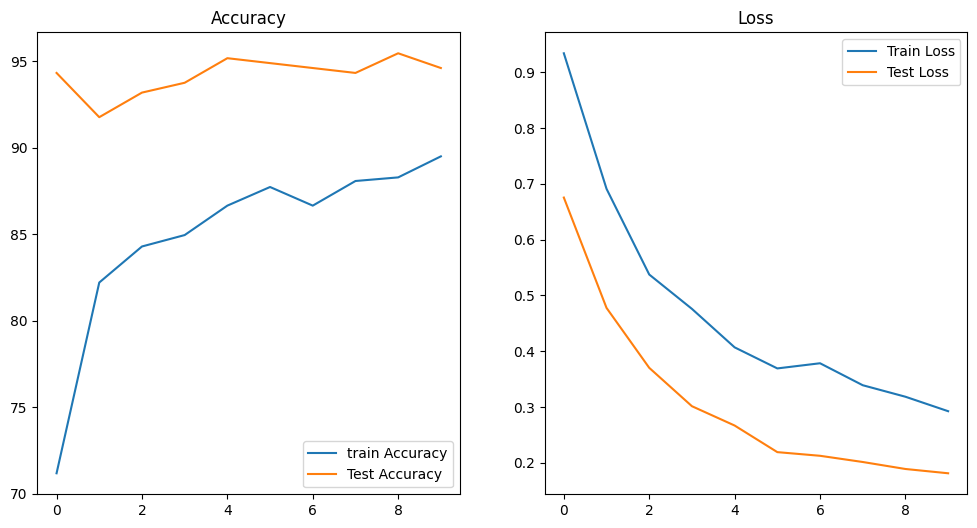

In [278]:
train_acc = results['train_acc']
train_loss = results['train_loss']
test_loss = results['test_loss']
test_acc = results['test_acc']

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(train_acc, label='train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Loss')
plt.legend()

Those are some excellent looking loss curves! 

It looks like the loss for both datasets (train and test) is heading in the right direction.

The same with the accuracy values, trending upwards.

That goes to show the power of **transfer learning**. Using a pretrained model often leads to pretty good results with a small amount of data in less time.

I wonder what would happen if you tried to train the model for longer? Or if we added more data?

> **Question:** Looking at the loss curves, does our model look like it's overfitting or underfitting? Or perhaps neither? Hint: Check out notebook [04. PyTorch Custom Datasets part 8. What should an ideal loss curve look like?](https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like) for ideas.

In [48]:
from typing import Dict, List, Tuple

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

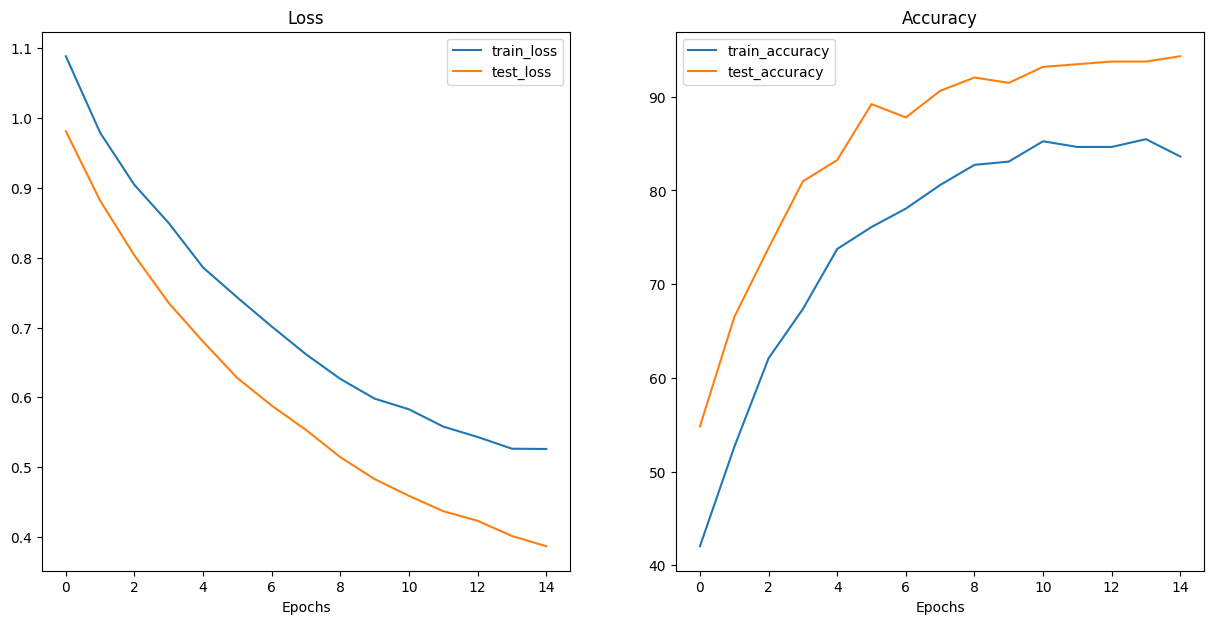

In [263]:
plot_loss_curves(results)

## 6. Make predictions on images from the test set

It looks like our model performs well quantitatively but how about qualitatively?

Let's find out by making some predictions with our model on images from the test set (these aren't seen during training) and plotting them.

*Visualize, visualize, visualize!*

One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in *same* format as the images our model was trained on.

This means we'll need to make sure our images have:
* **Same shape** - If our images are different shapes to what our model was trained on, we'll get shape errors.
* **Same datatype** - If our images are a different datatype (e.g. `torch.int8` vs. `torch.float32`) we'll get datatype errors.
* **Same device** - If our images are on a different device to our model, we'll get device errors.
* **Same transformations** - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make preidctions on images transformed in a different way, these predictions may be off.

> **Note:** These requirements go for all kinds of data if you're trying to make predictions with a trained model. Data you'd like to predict on should be in the same format as your model was trained on.

To do all of this, we'll create a function `pred_and_plot_image()` to:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open an image with [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open).
3. Create a transform for the image (this will default to the `manual_transforms` we created above or it could use a transform generated from `weights.transforms()`).
4. Make sure the model is on the target device.
5. Turn on model eval mode with `model.eval()` (this turns off layers like `nn.Dropout()`, so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with `torch.unsqueeze(dim=0)` so our input image has shape `[batch_size, color_channels, height, width]`.
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with `torch.softmax()`.
9. Convert model's prediction probabilities to prediction labels with `torch.argmax()`.
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8.

> **Note:** This is a similar function to [04. PyTorch Custom Datasets section 11.3's](https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function) `pred_and_plot_image()` with a few tweaked steps. 

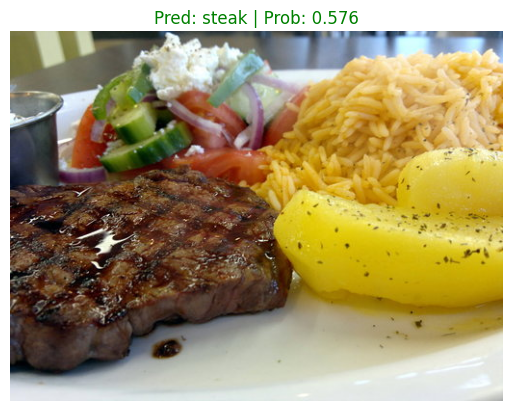

In [264]:
from PIL import Image
import random
# random.seed(7)

test_img_path = random.choice(list(test_dir.glob('*/*.jpg')))
def pred_and_plot_image(model: torch.nn.Module,
                        image_path:str,
                        class_names:List[str],
                        image_size: Tuple[int, int]=(224,224),
                        transform: torchvision.transforms=None,
                        color: str='green',
                        device: torch.device='cpu'):


    test_img = Image.open(image_path)
    if transform:
        test_img_tsfm = transform(test_img)
    else:
        test_img_tsfm = T.Compose([
                                   T.Resize(image_size),
                                   T.ToTensor(),
                                   T.Normalize(mean=[0.485, 0.456, 0.406],
                                               std=[0.229, 0.224, 0.225]),
                                 ])
    utils.to_device(model, device)
    test_img_tsfm = utils.to_device(test_img_tsfm, device)

    model.eval()
    with torch.inference_mode():
        pred_logits = model(test_img_tsfm.unsqueeze(0))

        pred_prob = torch.softmax(pred_logits, 1)

        pred_label = torch.argmax(pred_prob, 1)

    plt.figure()
    plt.imshow(test_img)
    plt.title(f"Pred: {class_names[pred_label]} | Prob: {pred_prob.max():.3f}", c=color)
    plt.axis(False)

pred_and_plot_image(model,
                   test_img_path, 
                    class_names,
                    transform=manual_transforms,
                    device=device)

What a good looking function!

Let's test it out by making predictions on a few random images from the test set.

We can get a list of all the test image paths using `list(Path(test_dir).glob("*/*.jpg"))`, the stars in the `glob()` method say "any file matching this pattern", in other words, any file ending in `.jpg` (all of our images).

And then we can randomly sample a number of these using Python's [`random.sample(populuation, k)`](https://docs.python.org/3/library/random.html#random.sample) where `population` is the sequence to sample and `k` is the number of samples to retrieve.

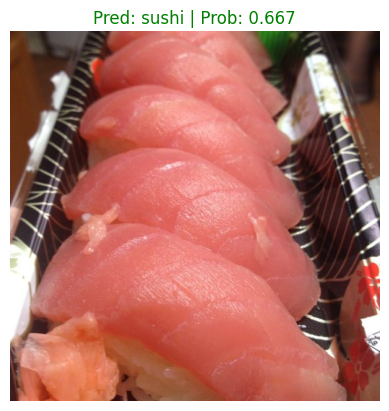

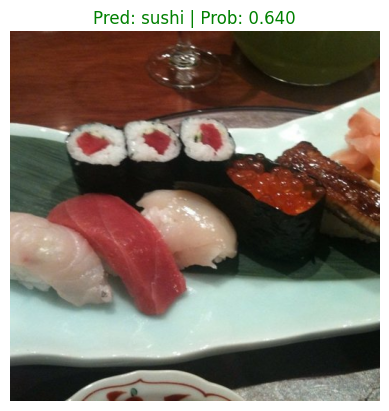

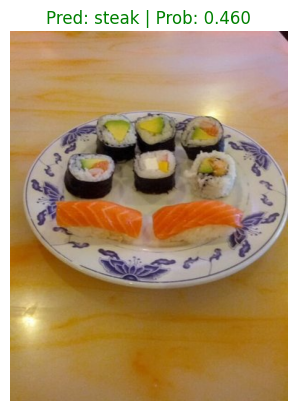

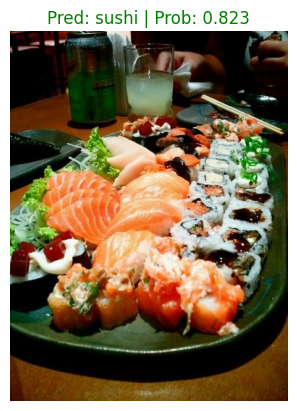

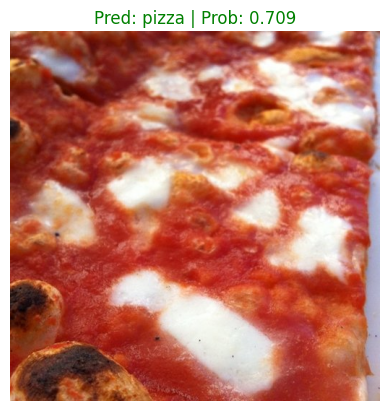

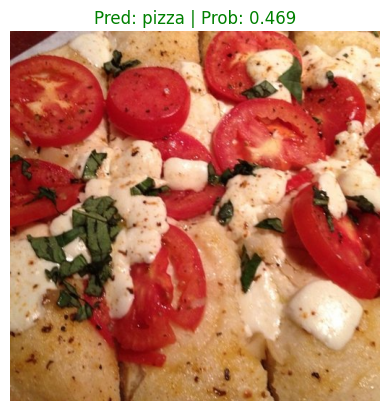

In [265]:
import random
# random.seed(7)

num_images_to_plot=6
test_img_path = random.sample(list(test_dir.glob('*/*.jpg')), 
                              k=num_images_to_plot)

for image_path in test_img_path:
    pred_and_plot_image(model,
                   image_path, 
                    class_names,
                    transform=manual_transforms,
                    device=device)

Woohoo!

Those predictions look far better than the ones our TinyVGG model was previously making.

### 6.1 Making predictions on a custom image

It looks like our model does well qualitatively on data from the test set.

But how about on our own custom image?

That's where the real fun of machine learning is!

Predicting on your own custom data, outisde of any training or test set.

To test our model on a custom image, let's import the old faithful `pizza-dad.jpeg` image (an image of my dad eating pizza).

We'll then pass it to the `pred_and_plot_image()` function we created above and see what happens.

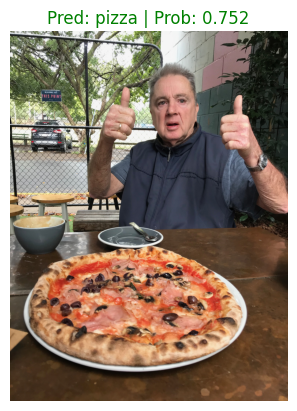

In [266]:
img_name = '04-pizza-dad.jpeg'
img_path = f'data/{img_name}'
pred_and_plot_image(model,
                   img_path, 
                    class_names,
                    transform=manual_transforms,
                    device=device)

Two thumbs up!

Looks like our model go it right again!

But this time the prediction probability is higher than the one from TinyVGG (`0.373`) in [04. PyTorch Custom Datasets section 11.3](https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function).

This indicates our `efficientnet_b0` model is *more* confident in its prediction where as our TinyVGG model was par with just guessing.

## Main takeaways
* **Transfer learning** often allows to you get good results with a relatively small amount of custom data.
* Knowing the power of transfer learning, it's a good idea to ask at the start of every problem, "does an existing well-performing model exist for my problem?"
* When using a pretrained model, it's important that your custom data be formatted/preprocessed in the same way that the original model was trained on, otherwise you may get degraded performance.
* The same goes for predicting on custom data, ensure your custom data is in the same format as the data your model was trained on.
* There are [several different places to find pretrained models](https://www.learnpytorch.io/06_pytorch_transfer_learning/#where-to-find-pretrained-models) from the PyTorch domain libraries, HuggingFace Hub and libraries such as `timm` (PyTorch Image Models).

## Exercises

All of the exercises are focused on practicing the code above.

You should be able to complete them by referencing each section or by following the resource(s) linked.

All exercises should be completed using [device-agnostic code](https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code).

**Resources:**
* [Exercise template notebook for 06](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/06_pytorch_transfer_learning_exercises.ipynb)
* [Example solutions notebook for 06](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb) (try the exercises *before* looking at this)
    * See a live [video walkthrough of the solutions on YouTube](https://youtu.be/ueLolShyFqs) (errors and all)

1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.
2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
    * Predicting across all of the test dataset, storing the labels and predicted probabilities.
    * Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
    * Plot the top 5 "most wrong" images, why do you think the model got these wrong? 
3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
4. Train the model from section 4 above for longer (10 epochs should do), what happens to the performance?
5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
    * You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb). 
6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
    * You'll have to change the size of the classifier layer to suit our problem.
    * You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  
## Extra-curriculum
* Look up what "model fine-tuning" is and spend 30-minutes researching different methods to perform it with PyTorch. How would we change our code to fine-tine? Tip: fine-tuning usually works best if you have *lots* of custom data, where as, feature extraction is typically better if you have less custom data.
* Check out the new/upcoming [PyTorch multi-weights API](https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/) (still in beta at time of writing, May 2022), it's a new way to perform transfer learning in PyTorch. What changes to our code would need to made to use the new API?
* Try to create your own classifier on two classes of images, for example, you could collect 10 photos of your dog and your friends dog and train a model to classify the two dogs. This would be a good way to practice creating a dataset as well as building a model on that dataset.

In [92]:
def prediction(model: torch.nn.Module,
               test_dataloader:torch.utils.data.DataLoader,
               class_names:List[str],
               device: torch.device='cpu'):
    
    pred_label_list = []
    test_label_list = []

    utils.to_device(model, device)
#     test_dataloader = utils.to_device(test_dataloader, device)

    model.eval()
    with torch.inference_mode():
        for Xb, yb in test_dataloader:
            pred_logits = model(Xb.to(device))

            pred_prob = torch.softmax(pred_logits, 1)

            pred_label = torch.argmax(pred_prob, 1)
            
            pred_label_list.append(pred_label.cpu())
            test_label_list.append(yb)
        
    return torch.cat(pred_label_list,0), torch.cat(test_label_list,0)

In [267]:
pred_label_tensors, test_label_tensors = prediction(model,
                                               test_dataloader,
                                               class_names,
                                               device)

<AxesSubplot:>

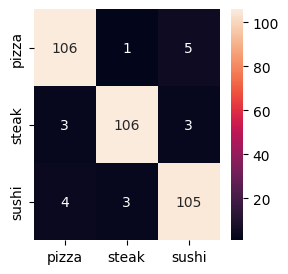

In [268]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_label_tensors.numpy(),pred_label_tensors.numpy())

plt.figure(figsize=(3,3))
sns.heatmap(cm,annot=True,fmt='.0f',xticklabels=class_names, yticklabels=class_names)

In [269]:
print(classification_report(test_label_tensors.numpy(), pred_label_tensors.numpy()))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       112
           1       0.96      0.95      0.95       112
           2       0.93      0.94      0.93       112

    accuracy                           0.94       336
   macro avg       0.94      0.94      0.94       336
weighted avg       0.94      0.94      0.94       336



In [248]:
test_img_dataset = test_dataloader.dataset.imgs

In [249]:
wrong_pred = torch.eq(pred_label_tensors, test_label_tensors)
wrong_idx = (wrong_pred==0).nonzero(as_tuple=True)[0]
wrong_idx

tensor([  5,  23,  41,  46,  47,  48,  51,  95, 119, 120, 128, 170, 227])

In [250]:
pred_label_tensors[:5], test_label_tensors[:5]

(tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0]))

data\new_food_file\food-101\test\steak\1627703.jpg
data\new_food_file\food-101\test\pizza\153195.jpg
data\new_food_file\food-101\test\steak\1206166.jpg
data\new_food_file\food-101\test\steak\1288540.jpg
data\new_food_file\food-101\test\pizza\254812.jpg
data\new_food_file\food-101\test\sushi\1091402.jpg


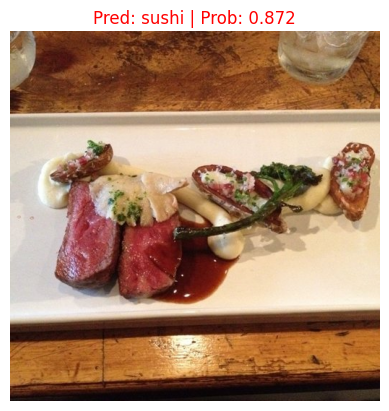

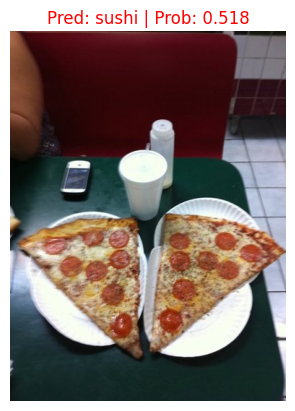

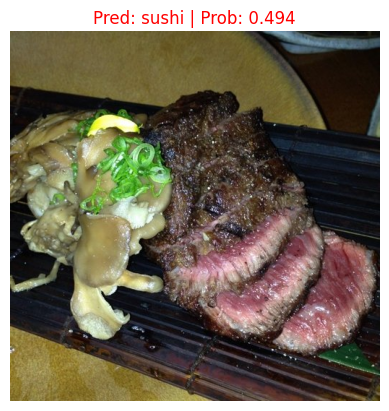

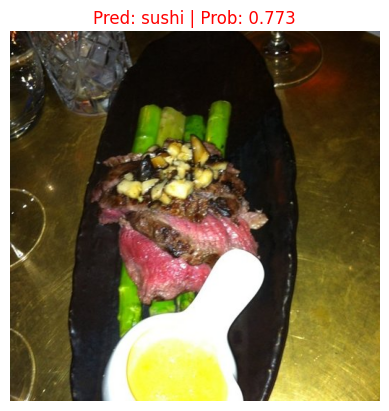

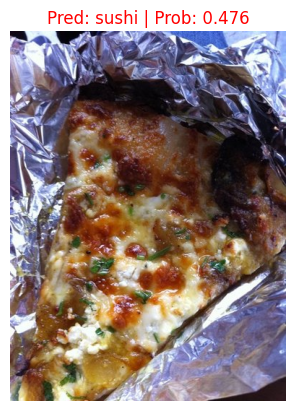

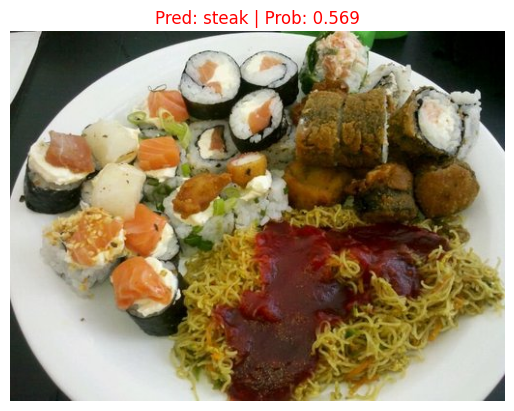

In [251]:
import random
# random.seed(7)

num_images_to_plot=6
wrong_pred_path = random.sample(wrong_idx.numpy().tolist(), 
                              k=num_images_to_plot)

for idx in wrong_pred_path:
    image_path, label = test_img_dataset[idx]
    print(image_path)
    pred_and_plot_image(model,
                   image_path, 
                    class_names,
                    transform=manual_transforms,
                    color='red',
                    device=device)

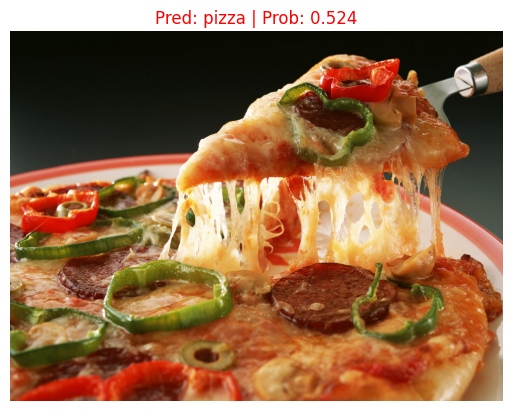

In [252]:
img_name = '2fSlice-of-Pizza-pizza-7383219-1600-1200.jpg'
img_path = f'data/{img_name}'
pred_and_plot_image(model,
                   img_path, 
                    class_names,
                    transform=manual_transforms,
                    color='red',
                    device=device)

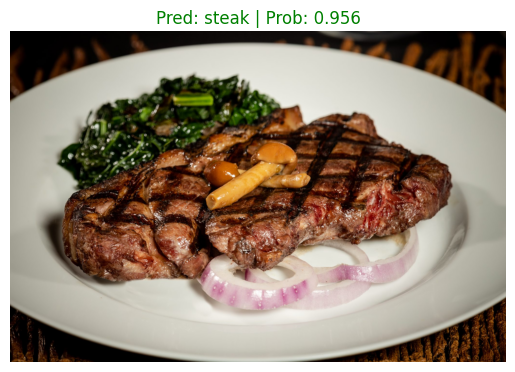

In [253]:
img_name = 'Bison-Boneless-Ribeye-Steak-Bison-Meat-Beck-Bulow-2048x1365.jpg'
img_path = f'data/{img_name}'
pred_and_plot_image(model,
                   img_path, 
                    class_names,
                    transform=manual_transforms,
                    color='green',
                    device=device)